# TFG: Dinámicas no lineales en sistemas híbridos clásico-cuánticos

In [1]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
import cProfile
#import mpld3
from sympy.physics.quantum import TensorProduct
#mpld3.enable_notebook()
from mpl_toolkits.mplot3d import axes3d
#from matplotlib import cm
#%matplotlib widget

from scipy.integrate import quad, dblquad
from scipy.linalg import expm, sinm, cosm
from sympy.solvers.polysys import solve_poly_system
from scipy.optimize import fsolve, least_squares, differential_evolution
from pyswarm import pso
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import mpmath as mp

In [3]:
Q, P, λ0, λ1, λ2, λ3, λ4, λ5, λ6, λ7, λ8, λ9, λ10, λ11, λ12, λ13, λ14, λ15= sym.symbols("Q, P, λ0, λ1, λ2, λ3, λ4, λ5, λ6, λ7, λ8, λ9, λ10, λ11, λ12, λ13, λ14, λ15 ", real = True )

f = sym.Function('f')(Q)
E0 = sym.Function('E0')(Q,P)
E1 = sym.Function('E1')(Q)
sym.init_printing(pretty_print=True)
#sym.init_vprinting

## Coordenadas de las Matrices de Densidad Híbridas

In [4]:
#Base lineal para cálculo numérico
QBasis_n=np.array([np.eye(2)/sym.sqrt(2), np.array([[0,1],[1,0]])/sym.sqrt(2), np.array([[0,-1j],[1j,0]])/sym.sqrt(2),np.array([[1,0],[0,-1]])/sym.sqrt(2)])

#Base lineal para cálculo simbólico
QBasis_sym=[sym.Matrix([[1,0],[0,1]])/sym.sqrt(2),  sym.Matrix([[0,1.0],[1.0,0]])/sym.sqrt(2), sym.Matrix( [[0,-1j],[1j,0]])/sym.sqrt(2),  sym.Matrix([[1.0,0],[0,-1.0]])/sym.sqrt(2)]


In [5]:
QBasis_sym #Comprobación de la base lineal simbólica

⎡⎡√2    ⎤                                                            ⎤
⎢⎢──  0 ⎥                                                            ⎥
⎢⎢2     ⎥  ⎡  0     0.5⋅√2⎤  ⎡   0      -0.5⋅√2⋅ⅈ⎤  ⎡0.5⋅√2     0   ⎤⎥
⎢⎢      ⎥, ⎢              ⎥, ⎢                   ⎥, ⎢               ⎥⎥
⎢⎢    √2⎥  ⎣0.5⋅√2    0   ⎦  ⎣0.5⋅√2⋅ⅈ      0    ⎦  ⎣  0     -0.5⋅√2⎦⎥
⎢⎢0   ──⎥                                                            ⎥
⎣⎣    2 ⎦                                                            ⎦

In [6]:
#Construcción de la base cuadrática simétrica

Rho00 = sym.Matrix(TensorProduct(QBasis_sym[0], QBasis_sym[0]))

Rho0K = [sym.Matrix(1/2*(TensorProduct(QBasis_sym[0], k) + TensorProduct(k, QBasis_sym[0]))) for k in QBasis_sym[1:]]

RhoIJ = [sym.Matrix(1/2*(TensorProduct(QBasis_sym[k], QBasis_sym[k+1]) + TensorProduct(QBasis_sym[k+1], QBasis_sym[k]))) for k in range(1,3)]

Rho13 = sym.Matrix(1/2*(TensorProduct(QBasis_sym[1], QBasis_sym[3]) + TensorProduct(QBasis_sym[3], QBasis_sym[1])))

RhoKK = [sym.Matrix(TensorProduct(k, k)) for k in QBasis_sym[1:]]


QBasis2_sym =sym.flatten([[Rho00], Rho0K, RhoIJ, [Rho13], RhoKK], levels = 1)


In [7]:
QBasis2_sym #Comprobación de la base cuadrática simétrica

⎡⎡1/2   0    0    0 ⎤  ⎡ 0    0.25  0.25   0  ⎤  ⎡  0     -0.25⋅ⅈ  -0.25⋅ⅈ    
⎢⎢                  ⎥  ⎢                      ⎥  ⎢                            
⎢⎢ 0   1/2   0    0 ⎥  ⎢0.25   0     0    0.25⎥  ⎢0.25⋅ⅈ     0        0     -0
⎢⎢                  ⎥, ⎢                      ⎥, ⎢                            
⎢⎢ 0    0   1/2   0 ⎥  ⎢0.25   0     0    0.25⎥  ⎢0.25⋅ⅈ     0        0     -0
⎢⎢                  ⎥  ⎢                      ⎥  ⎢                            
⎣⎣ 0    0    0   1/2⎦  ⎣ 0    0.25  0.25   0  ⎦  ⎣  0     0.25⋅ⅈ   0.25⋅ⅈ     

 0   ⎤  ⎡0.5  0  0   0  ⎤  ⎡  0    0  0  -0.5⋅ⅈ⎤  ⎡  0     -0.25⋅ⅈ  -0.25⋅ⅈ   
     ⎥  ⎢               ⎥  ⎢                   ⎥  ⎢                           
.25⋅ⅈ⎥  ⎢ 0   0  0   0  ⎥  ⎢  0    0  0    0   ⎥  ⎢0.25⋅ⅈ     0        0     0
     ⎥, ⎢               ⎥, ⎢                   ⎥, ⎢                           
.25⋅ⅈ⎥  ⎢ 0   0  0   0  ⎥  ⎢  0    0  0    0   ⎥  ⎢0.25⋅ⅈ     0        0     0
     ⎥  ⎢               ⎥  ⎢                   ⎥  ⎢

In [8]:
#A continuación crearemos las funciones que designen las coordenadas de rho en nuestra base

Coords2 = [λ0, λ1, λ2, λ3, λ4, λ5, λ6, λ7, λ8, λ9] #La lista de los símbolos que representan a las coordenadas

def ProyQBasis_sym(ρ): #Proyecta la matriz ρ sobre los elementos de la base QBasis_sym
    
    result = [((k*ρ).trace())/2 for k in QBasis_sym]
    return result

def ProyQBasis2_sym(ρ): #Proyecta la matriz ρ sobre los elementos de la base QBasis2_sym
    
    result = [((k*ρ).trace())/((k*k).trace()) for k in QBasis2_sym]
    return result

def CoordsMatrix_sym(coords): #Genera una matriz a partir de sumar los productos de los elementos del vector coordenadas con los elementos de la base QBasis_sym
    
    result = sym.zeros(2)
    AuxCoords = [coords[k]*QBasis_sym[k] for k in range(len(coords))] 
    for i in AuxCoords:
        result += i
    res =  result.applyfunc(sym.simplify) 
    return res

def CoordsMatrix2_sym(coords):  #Genera una matriz a partir de sumar los productos de los elementos del vector coordenadas con los elementos de la base QBasis2_sym
    
    result = sym.zeros(4)
    AuxCoords = [coords[k]*QBasis2_sym[k] for k in range(len(coords))] 
    for i in AuxCoords:
        result += i
    res =  result.applyfunc(sym.simplify) 
    return res



In [9]:
ProyQBasis2_sym(QBasis2_sym[0])

In [10]:
Rho = CoordsMatrix2_sym(Coords2) #Generamos la matriz Rho correspondiente a la distribución de probabilidad condicionadd

Rho

⎡              λ₀   λ₃   λ₉                                                   
⎢              ── + ── + ──                 0.25⋅λ₁ - 0.25⋅ⅈ⋅λ₂ - 0.25⋅ⅈ⋅λ₅ + 
⎢              2    2    2                                                    
⎢                                                                             
⎢0.25⋅λ₁ + 0.25⋅ⅈ⋅λ₂ + 0.25⋅ⅈ⋅λ₅ + 0.25⋅λ₆               0.5⋅λ₀ - 0.5⋅λ₉      
⎢                                                                             
⎢0.25⋅λ₁ + 0.25⋅ⅈ⋅λ₂ + 0.25⋅ⅈ⋅λ₅ + 0.25⋅λ₆               0.5⋅λ₇ + 0.5⋅λ₈      
⎢                                                                             
⎣       0.5⋅ⅈ⋅λ₄ + 0.5⋅λ₇ - 0.5⋅λ₈          0.25⋅λ₁ + 0.25⋅ⅈ⋅λ₂ - 0.25⋅ⅈ⋅λ₅ - 

                                                                              
0.25⋅λ₆  0.25⋅λ₁ - 0.25⋅ⅈ⋅λ₂ - 0.25⋅ⅈ⋅λ₅ + 0.25⋅λ₆         -0.5⋅ⅈ⋅λ₄ + 0.5⋅λ₇ 
                                                                              
                                                   

In [11]:
Rho.trace() #Traza de Rho, sirve para ver que λ0 = 1/2

In [12]:
Purity = (Rho**2).trace() #Cálculo de la pureza de Rho, tiene que ser menor o igual que 1

Purity

In [13]:
EigenValues = Rho.eigenvals(multiple=True) #Creamos el vector con los autovalores de Rho

In [14]:
EigenValues[0]

## Máxima Entropía.

Buscamos ahora encontrar las expresiones de las coordenadas cuadráticas $\mu_{ij}$ que maximicen la entropía. Teniendo en cuenta la entropía de Rényi:

$S_{\alpha} = \frac{1}{1-\alpha}log(Tr[(\rho^{\otimes 2})^{\alpha}]) = \frac{1}{1-\alpha}log(\sum_{k=0}^{3} \Lambda_{k}^{\alpha})$;  Donde $\Lambda_{k}$ son los autovalores en este caso.

Si observamos la expresión de la entropía, el logaritmo es una función estrictamente creciente, por lo que encontramos dos casos:

- $\alpha < 1$ $\longrightarrow$ Minimizar los autovalores maximiza la entropía

- $\alpha > 1$ $\longrightarrow$ Maximizar los autovalores maximiza la entropía

Con el fin de estudiar más adelante una comparación con el truncamiento en serie de la entropía de Shannon (Von Neumann), trabajaremos en $\alpha \sim 1$.

Además, podemos suponer que la optimización de las coordenadas $\mu_{ij}$ sujetas a las restricciones impuestas al sistema es simétrica con respecto a los grados de libertad. Es decir, si tenemos la restricción:

$\sum_{j=0}^{3} \mu_{jj} = 1/2$  $\Longrightarrow$  $\mu_{jj} = \frac{1}{6}\;\; \forall j = 1,2,3$;


Salvo que exista una restricción que lo exprese explícitamente, todas los grados tienen el mismo peso en las restricciones.

In [15]:
eig=[k.copy().subs([(λ0,1/2),(λ7,1/6),(λ8,1/6),(λ9,1/6)]) for k in EigenValues] #Hacemos una copia de los autovalores de Rho y sutituimos las restricciones

In [16]:
eig[0].round(1) #Comprobación de los autovalores

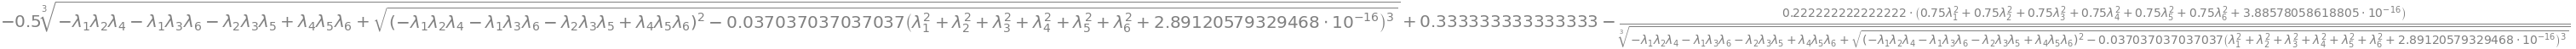

In [17]:
eig[1] #Comprobación de los autovalores

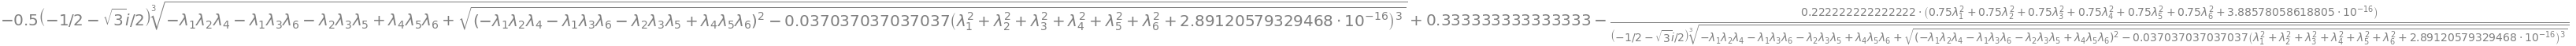

In [18]:
eig[2] #Comprobación de los autovalores

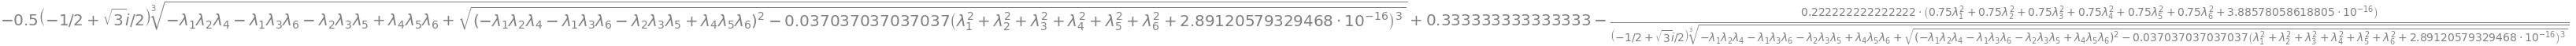

In [19]:
eig[3] #Comprobación de los autovalores

In [20]:
#Podemos expresar los autovalores en función de dos parámetros, C y P, que dependen de las coordenadas cuadráticas

C = -1/2*(λ1*λ2*λ4 + λ1*λ3*λ6 + λ2*λ3*λ5) + λ4*λ5*λ6
P = 1/2*(λ1**2 + λ2**2 + λ3**2) + λ4**2 + λ5**2 + λ6**2

C, P = sym.symbols("C, P", real = True)

In [21]:
#Generamos el vector que recoge los autovalores habiendo sustituido C y P

EIG = [sym.nsimplify(k.subs([(-1*(λ1*λ2*λ4 + λ1*λ3*λ6 + λ2*λ3*λ5) + λ4*λ5*λ6, C), (λ1**2 + λ2**2 + λ3**2 + λ4**2 + λ5**2 + λ6**2, P)]), tolerance = 0.01, rational = True) for k in eig]

In [22]:
EIG[0]

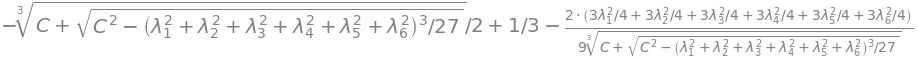

In [23]:
EIG[1]

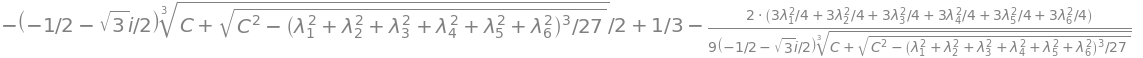

In [24]:
EIG[2]

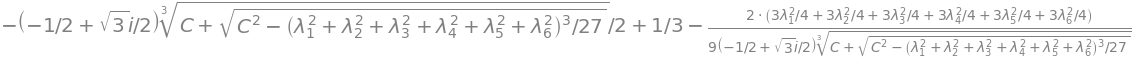

In [25]:
EIG[3]

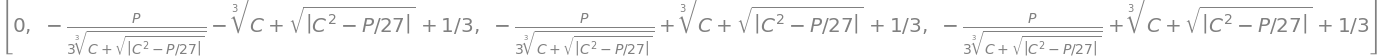

In [26]:
#Como la expresión .subs() tiene dificultades para sustituir P, definiremos los autovalores manualmente:

#Además sustituiremos los coeficientes complejos correspondientes a la raíz cúbica de +1,-1 por la única raíz real

# 

Eigen = [0, 0, 0, 0]

Eigen[1] = sym.nsimplify(-(C + sym.sqrt(sym.Abs(C**2 - P/27)))**(1/3) + 1/3*(1 - P/((C + sym.sqrt(sym.Abs(C**2 - P/27)))**(1/3))), tolerance = 0.01, rational = True)

Eigen[2] =  sym.nsimplify((C + sym.sqrt(sym.Abs(C**2 - P/27)))**(1/3) + 1/3*(1 - P/((C + sym.sqrt(sym.Abs(C**2 - P/27)))**(1/3))), tolerance = 0.01, rational = True)

Eigen[3] = sym.nsimplify((C + sym.sqrt(sym.Abs(C**2 - P/27)))**(1/3) + 1/3*(1 - P/((C + sym.sqrt(sym.Abs(C**2 - P/27)))**(1/3))), tolerance = 0.01, rational = True)

Eigen

In [27]:
#Para encontrar el máximo de los autovalores Λ1, Λ2 y Λ3, primero calculamos sus derivadas parciales con respecto a C y P:

eigdiffC = Eigen.copy()
eigdiffP = Eigen.copy()

for n in range(4):
    eigdiffC[n]=sym.diff(Eigen[n],C)
    eigdiffP[n]=sym.diff(Eigen[n],P)

#Ahora, igualamos dichas derivadas a cero:

var = [C,P]
sistema = np.zeros(3,dtype=np.ndarray)
for n in range(1,4): #Creamos un array donde sus componenetes son subarrays que contienen las ecuaciones de los sistemas para cada autovalor
    sistema[n-1] = [eigdiffC[n], eigdiffP[n]] #La componente sistema[0] equivale al primer autovalor


In [28]:
#Una vez creado el sistema de ecuaciones, buscaremos una forma de resolverlo, ya sea mediante métodos analíticos o numéricos:

#Mediante sym.nsolve():

Eqs_sistema = [[sym.Eq(eigdiffC[k], 0), sym.Eq(eigdiffP[k], 0)] for k in range(1,4)]

Eqs_sistema_flat = sym.flatten(Eqs_sistema, levels = 1 )

#soluciones = sym.nsolve(Eqs_sistema_flat, var, [0,1/3], tol=1e-4) #Este método numérico no funciona (no consigue encontrar las soluciones en el rango)
#soluciones

In [29]:


#Probamos por el método de mínimos cuadrados:

j = sym.I #Declaración de j como unidad imaginaria

#Reescribimos el código para que no minimice las derivadas, sino los propios autovalores:

eq1 = Eigen[1]
eq2 = Eigen[2]
eq3 = Eigen[3]

#Funciones lambdify para convertir las ecuaciones simbólicas a funciones numéricas

eq1_func = sym.lambdify((C, P), eq1, modules='numpy')
eq2_func = sym.lambdify((C, P), eq2, modules='numpy')
eq3_func = sym.lambdify((C, P), eq3, modules='numpy')

#Función que evalúa las ecuaciones 
def equations(vars):
    C_val, P_val = vars
    
    #Comprobamos si el valor bajo la raíz cuadrada es negativo
    if P_val == 0:
        return [1e10] * 6  # Valor grande si la raíz cuadrada es negativa para que el algoritmo descarte esa solución
    
    eq1_f = eq1_func(C_val, P_val)
    eq2_f = eq2_func(C_val, P_val)
    eq3_f = eq3_func(C_val, P_val)

    #Verificamos si alguna de las evaluaciones es NaN o infinita
    if not np.all(np.isfinite([eq1_f, eq2_f, eq3_f])):
        return [1e10] * 6  # Valor grande si hay NaN o infinito para que el algoritmo descarte esa solución
    
    return [eq1_f, eq2_f, eq3_f]

#Intervalo de búsqueda para las variables
bounds = ([-2, 1e-8], [2, 1/3])  # Ejemplo de límites
initial_guess = [1, 1/3]  # Ejemplo de punto inicial

#Resolver el sistema usando least_squares
result = least_squares(equations, initial_guess, bounds=bounds)

#Verificar la solución
if result.success:
    print("Solución encontrada:", result.x)
    print("Evaluación de las ecuaciones en la solución encontrada:", equations(result.x))
else:
    print("No se encontró una solución")


Solución encontrada: [0.11103849 0.33289775]
Evaluación de las ecuaciones en la solución encontrada: [-0.3782010178217094, 0.5831682030027412, 0.5831682030027412]


<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in scalar power
  return -1/3*P/(C + sqrt(abs(C**2 - 1/27*P)))**(1/3) - (C + sqrt(abs(C**2 - 1/27*P)))**(1/3) + 1/3
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in scalar power
  return -1/3*P/(C + sqrt(abs(C**2 - 1/27*P)))**(1/3) + (C + sqrt(abs(C**2 - 1/27*P)))**(1/3) + 1/3
<lambdifygenerated-3>:2: RuntimeWarning: invalid value encountered in scalar power
  return -1/3*P/(C + sqrt(abs(C**2 - 1/27*P)))**(1/3) + (C + sqrt(abs(C**2 - 1/27*P)))**(1/3) + 1/3


In [30]:
#Esto es con el algoritmo de differential evolution

bounds_diff = [(-2, 2), (1, 4/3)]
def objective(vars):
    return np.sum(np.array(equations(vars)) ** 2) #Como en la entropía trabajaremos con 𝛼 > 1, dejamos así el objetivo a minimizar, ya que 1/(1-𝛼) < 0

#Ejecutar optimización global con differential_evolution
result = differential_evolution(objective, bounds_diff)

#Mostrar resultados
if result.success:
    print("Solución encontrada:")
    print("C =", result.x[0])
    print("P =", result.x[1])
    print("Valor de la función objetivo:", result.fun)
else:
    print("No se encontró una solución.")

Solución encontrada:
C = -0.07500514651878008
P = 1.0
Valor de la función objetivo: 0.7331373984093084


In [31]:
#Probemos ahora con Particle Swarm Optimization:
bounds_pso = np.array(bounds_diff)
best_solution, best_value = pso(objective, bounds_pso[:, 0], bounds_pso[:, 1], swarmsize=50, maxiter=500)

best_solution
#best_value

Stopping search: Swarm best objective change less than 1e-08


array([-0.07502415,  1.        ])

In [32]:
#Comprobación rápida
valoresmax = {C: -0.07357053330682661, P: 1.0006081422703224}

AutoV = [0, 0, 0, 0]

for k in range(1,4):

    AutoV[k] = sym.simplify(sym.sqrt(Eigen[k].evalf(subs=valoresmax)*sym.conjugate(Eigen[k].evalf(subs=valoresmax))))

print("Los autovalores son:")

for i in range(len(AutoV)):
    print(f"\nΛ{i} = {AutoV[i]}")
    
print("\nY la entropía de Rényi queda:")

def AutoValores(Eigen, valoresmax):
    
    AutoV = [0, 0, 0, 0]
    
    for k in range(1,4):

        AutoV[k] = sym.simplify(sym.sqrt(Eigen[k].evalf(subs=valoresmax)*sym.conjugate(Eigen[k].evalf(subs=valoresmax))))
    
    return AutoV

def S (Λ, alpha):
    Λ_sum = sum([l**alpha for l in Λ])
    return (1/(1-alpha))*sym.log(Λ_sum)

def S_VN (Λ, alpha):
    Λ_sum = sum([l**alpha for l in Λ])
    return 1 - Λ_sum 


print("\nS =", S(AutoV,2)) #differential evolution parece dar la solución para C y P que proporciona la máxima entropía

Los autovalores son:

Λ0 = 0

Λ1 = 0.845933787716398

Λ2 = 0.0955797779547458

Λ3 = 0.0955797779547458

Y la entropía de Rényi queda:

S = 0.309416617593231


## Obtención de las coordenadas cuadráticas

Una vez ya tenemos las expresiones de P y C que maximizan la entropía, habremos de despejar las coordenadas:

$P = \lambda_{1}^{2} + \lambda_{2}^{2} + \lambda_{3}^{2} + \lambda_{4}^{2} + \lambda_{5}^{2} + \lambda_{6}^{2}$

$C = -(\lambda_{1}\lambda_{2}\lambda_{4} + \lambda_{1}\lambda_{3}\lambda_{6} + \lambda_{2}\lambda_{3}\lambda_{5}) + \lambda_{4}\lambda_{5}\lambda_{6}$

Para facilitar el hallazgo de los valores de los $\lambda_i$ que maximicen C y P, tomaremos en consideración algunas características.

- En primer lugar, podemos tomar conjuntos de los $\lambda_i$ en función de los elementos de la base a los que acompañan, separando así $\{\lambda_{1},\lambda_{2},\lambda_{3}\}$ y $\{\lambda_{4},\lambda_{5},\lambda_{6}\}$

- Identidicamos las sumas cuadráticas de los elementos de estos conjuntos como los radios de las esferas que recogen los posibles estados correspondientes a la base de la cual son coordenadas, es decir, son los espacios de coordenadas cuadráticas.

- Como todos los puntos del espacio son equivalentes entre sí, para facilitar los cálculos sin perder generalidad tomaremos:
    
    --> $\lambda_{1}, \lambda_{2}, \lambda_{3} \;\; están\;fijos$
    
    --> $\lambda_{4} = \lambda,\; \lambda_{5} = 0,\; \lambda_{6} = 0\; \Longrightarrow \lambda_{4}^{2} + \lambda_{5}^{2} + \lambda_{6}^{2} = \lambda^{2}$
    
Por consiguiente, tendremos que:

$P_{max} = \lambda_{1}^2 + \lambda_{2}^2 + \lambda_{3}^2 + \lambda^2$

$C_{max} = -\lambda_{1}\lambda_{2}\lambda$

In [33]:
# Definir las variables simbólicas
lam, lam1, lam2, lam3 = sym.symbols("lam lam1 lam2 lam3", real=True, positive=True)

lam1 = 1/4
lam2 = 1/4
lam3 = 1/4

# Estos serán los valores que alcanzan C y P maximizando la entropía
PMAX = 1.0006081422703224
CMAX = -0.07357053330682661

# Definir las funciones PMAX y CMAX
"""
eq_P = lam1**2 + lam2**2 + lam3**2 + lam**2 - PMAX
eq_C = -lam1*lam2*lam - CMAX
"""
"""
eq_P = lam1**2 + lam2**2 + lam3**2 + 2*lam**2 - PMAX
eq_C = -lam1*lam2*lam -lam2*lam3*lam- CMAX
"""
eq_P = lam1**2 + lam2**2 + lam3**2 + 3*lam**2 - PMAX
eq_C = -lam1*lam2*lam -lam2*lam3*lam - lam1*lam3*lam + lam**3 - CMAX


#Ecuaciones de restricción
restrict_lam = lam >= 0

# Funciones de restricción evaluables (utilizadas para filtrar en nsolve)
def restrict_lam_func(lam_val, mu_val):
    return lam_val >= 0
"""
#nonlinsolve no respeta las restricciones impuestas
#Usar nonlinsolve para resolver el sistema

soluciones = sym.nonlinsolve([eq_P, eq_C, restrict_lam], [lam])
"""
# Usar nsolve para encontrar una solución numérica
soluciones = sym.nsolve([eq_P, eq_C], [lam], [1/2], tol=1e-1)



# Escribir las soluciones filtradas
print("Soluciones:")
for sol in soluciones:
    print(sol)

Soluciones:
0.500000000000000


## Integrador 

En los apartados anteriores, hemos estado buscando a ciegas el punto de máxima entropía, ya que no habíamos tenido en cuenta que ciertas coordenadas cuadráticas vienen fijas por las lineales:

$\mu_{0k} = \lambda_k = \frac{\mu_k}{2}\;\; \forall k = 1,2,3$ 

Por consiguiente, habremos de elaborar el algoritmo que encuentra las coordenadas de máxima entropía dentro del integrador. El esquema sería el siguiente:


1 - Partimos de un punto inicial $\{\lambda_1, \lambda_2, \lambda_3\}(t_0)$

2 - Calculamos el punto de máxima entropía $\{\lambda_4, \lambda_5, \lambda_6\}|_{MaxEnt}$

3 - Hallamos la evolución del punto inicial $\{\lambda_1, \lambda_2, \lambda_3\}(t_0 + \Delta t)$

Las funciones que determinan la evolución de las coordenadas cuadráticas será:

$\dot\mu_j (\xi) = \dot\lambda_j (\xi) = \sum_{k,l} c_{k,l}^j \mu_k (\xi) H_l (\xi) + \frac{1}{2}\{H_0 (\xi),\mu_j (\xi)\}_C + \sum_k \{H_k (\xi), \mu_{jk} (\xi)\}_C$

El Hamiltoniano que emplearemos será el siguiente:

$\hat H(\xi) = \frac{1}{2}(R^2 + P^2)\mathbb{I}_2 + E_1(R,P)\hat\pi_1(R,P) + E_2\hat\pi_2(R,P)$

Donde:

$\hat\pi_1(R,P) = \hat\sigma_0 sin(R)\hat\sigma_1 + cos(R)\hat\sigma_3$

$\hat\pi_2(R,P) = \hat\sigma_0 -sin(R)\hat\sigma_1 - cos(R)\hat\sigma_3$


$E_1(R,P) = \frac{1}{1+R^2}$

$E_2(R,P) = E_1(R,P) + 1 + \frac{R^2}{10}$

Además, hemos de tener en cuenta que $\mu_j (\xi) = F_C (\xi) \mu_j$, donde:

$F_C (\xi) = \frac{1}{2\pi}exp\left(-\frac{R^2+P^2}{2}\right)$

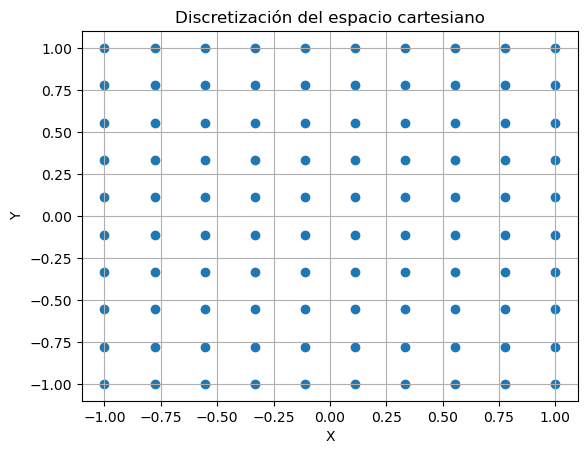

In [34]:
#Creamos la discretización del espacio de fases para el método de diferencias finitas

def MalladoEspacioClasico (n, x_min, x_max, y_min, y_max):
    
    #Arrays de n componentes equiespaciados para X e Y
    x = np.linspace(x_min, x_max, n)
    y = np.linspace(y_min, y_max, n)
    
    #Creamos la cuadrícula con coordenadas xx e yy
    xx, yy = np.meshgrid(x, y)
    
    #Y ahora la malla agrupando dichas coordenadas en un array cuadrado nxn
    Malla = np.stack((xx, yy), axis=-1)
    
    
    return Malla

N = 10 #dimensiones de la malla, correspondiente al espacio de fases clásico

q_min = -1
q_max = 1

p_min = -1
p_max = 1

EspClasico = MalladoEspacioClasico(N, q_min, q_max, p_min, p_max)



def plot_Malla(EspClasico):
    x = EspClasico[:, :, 0].flatten()
    y = EspClasico[:, :, 1].flatten()
    
    plt.scatter(x, y)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Discretización del espacio cartesiano')
    plt.grid(True)
    plt.show()


plot_Malla(EspClasico)

In [35]:
#Definimos las funciones F_C (inicial) y H_k

def F_C_inicial (R,P):
    return 1/(2*np.pi)*np.exp(-(R**2 + P**2)/(5))

def H_0 (R,P):
    E1 = 1/(1+R**2)
    E2 = 1/(1+R**2) + 1 + R**2/10
    return 1/2*(R**2 + P**2) + E1 + E2

def H_1 (R,P):
    E1 = 1/(1+R**2)
    E2 = 1/(1+R**2) + 1 + R**2/10
    return E1*np.sin(R) - E2*np.sin(R)

def H_3 (R,P):
    E1 = 1/(1+R**2)
    E2 = 1/(1+R**2) + 1 + R**2/10
    return E1*np.cos(R) - E2*np.cos(R)

#Ahora definimos las derivadas parciales por diferencias finitas

def parcial_q (f, val_i, val_f):
    
    q_i, p_i = val_i
    q_f, p_f = val_f
    
    dif_f = f(q_f,p_f) - f(q_i,p_i)
    dif_val = q_f - q_i
    
    return dif_f/dif_val

def parcial_p (f, val_i, val_f):
    
    q_i, p_i = val_i
    q_f, p_f = val_f
    
    dif_f = f(q_f,p_f) - f(q_i,p_i)
    dif_val = p_f - p_i
    
    return dif_f/dif_val


#Creamos un bucle que recorra EspClasico evaluando las diferencias finitas

Part_H0_q = np.zeros((N,N))
Part_H0_p = np.zeros((N,N))

Part_H1_q = np.zeros((N,N))
Part_H1_p = np.zeros((N,N))

Part_H3_q = np.zeros((N,N))
Part_H3_p = np.zeros((N,N))

Part_FC_q = np.zeros((N,N))
Part_FC_p = np.zeros((N,N))



for i in range(N):
    for j in range(N-1):
        val_i_q = EspClasico[i, j]
        val_f_q = EspClasico[i, j + 1]
        
        Part_H0_q[i, j] = parcial_q(H_0, val_i_q, val_f_q)
        Part_H1_q[i, j] = parcial_q(H_1, val_i_q, val_f_q)
        Part_H3_q[i, j] = parcial_q(H_3, val_i_q, val_f_q)
        Part_FC_q[i, j] = parcial_q(F_C_inicial, val_i_q, val_f_q)

for i in range(N - 1):
    for j in range(N):
        val_i_p = EspClasico[i, j]
        val_f_p = EspClasico[i + 1, j]
        
        Part_H0_p[i, j] = parcial_p(H_0, val_i_p, val_f_p)
        Part_H1_p[i, j] = parcial_p(H_1, val_i_p, val_f_p)
        Part_H3_p[i, j] = parcial_p(H_3, val_i_p, val_f_p)
        Part_FC_p[i, j] = parcial_p(F_C_inicial, val_i_p, val_f_p)

        
        
        
        

#Ahora generamos unos vectores que contengan las amtrices de las diferencias de H

Part_H_q = [Part_H0_q, Part_H1_q, np.zeros((N,N)), Part_H3_q]

Part_H_p = [Part_H0_p, Part_H1_p, np.zeros((N,N)), Part_H3_p]
        

"""        
print("Part_FC_q:")
print(Part_FC_q)
print("Part_FC_p:")
print(Part_FC_p)

print("Las dimensiones de las matrices son:")
print(Part_H0_q.shape)
"""

Part_H_q[3][:,:]

array([[-0.72559082, -0.54114785, -0.35831902, -0.17821798,  0.        ,
         0.17821798,  0.35831902,  0.54114785,  0.72559082,  0.        ],
       [-0.72559082, -0.54114785, -0.35831902, -0.17821798,  0.        ,
         0.17821798,  0.35831902,  0.54114785,  0.72559082,  0.        ],
       [-0.72559082, -0.54114785, -0.35831902, -0.17821798,  0.        ,
         0.17821798,  0.35831902,  0.54114785,  0.72559082,  0.        ],
       [-0.72559082, -0.54114785, -0.35831902, -0.17821798,  0.        ,
         0.17821798,  0.35831902,  0.54114785,  0.72559082,  0.        ],
       [-0.72559082, -0.54114785, -0.35831902, -0.17821798,  0.        ,
         0.17821798,  0.35831902,  0.54114785,  0.72559082,  0.        ],
       [-0.72559082, -0.54114785, -0.35831902, -0.17821798,  0.        ,
         0.17821798,  0.35831902,  0.54114785,  0.72559082,  0.        ],
       [-0.72559082, -0.54114785, -0.35831902, -0.17821798,  0.        ,
         0.17821798,  0.35831902,  0.54114785

In [36]:
#Creamos el tensor F_C(i,j,t) = NxNxT que ejercerá como variable en el integrador

T = 25 #Dimensión temporal, equivalente al número de pasos temporales en el integrador

F_C = np.zeros((N,N,T)) #El tensor que ejercerá como variable
H0 = np.zeros((N,N))
H1 = np.zeros((N,N))
H2 = np.zeros((N,N))
H3 = np.zeros((N,N))
Mu_0 = np.zeros((N,N,T))
Mu_1 = np.zeros((N,N,T))
Mu_2 = np.zeros((N,N,T))
Mu_3 = np.zeros((N,N,T))

Mu_vector = np.zeros((4,N,N,T))

#Ahora copiamos la matriz de F_C_inicial a la primera componente temporal del tensor variable, rellenamos las H_k y las Mu_j

for i in range(N):
    for j in range(N):
        r, p = EspClasico[i, j]
        F_C[i, j, 0] = F_C_inicial(r, p)
        H0[i,j] = H_0(r, p)
        H1[i,j] = H_1(r, p)
        H3[i,j] = H_3(r, p)
        #Valores iniciales de los Mu_j
        Mu_vector[0, i, j, :] = 1/np.sqrt(2) #Mu_0 es constante a lo largo del tiempo
        Mu_vector[1, i, j, 0] = 1/np.sqrt(6)
        Mu_vector[2, i, j, 0] = 1/np.sqrt(6)
        Mu_vector[3, i, j, 0] = 1/np.sqrt(6)
        
        
#Ahora un vector que guarde las H_k y las Mu_j

H_vector = [H0, H1, H2, H3]   

        

In [37]:
#Generaremos una serie de arrays que contengan posibles valores de P y C según su rango posible

N_valores = 50

#Array de valores de P:

P_valores = np.linspace(1, 4/3, N_valores)

#Array de valores de C (Caso 1):

C_valores_caso1 = np.linspace(-1/3, 1/3, N_valores)

#Array de valores de C (Caso 2):

C_valores_caso2 = np.linspace(-2/3, 2/3, N_valores)

#Array de valores de C (Caso 3):

C_valores_caso3 = np.linspace(-2, 2, N_valores)




#Ahora buscamos definir una función que pruebe varios valores de C y P en sus intervalos según el caso y devuelva el mu_jk de MaxEnt

def CP_MaxEnt (Caso, P_valores, C_valores_caso1, C_valores_caso2, C_valores_caso3, Vector_Mu, c):
    
    Matriz_CP = np.zeros((N_valores, N_valores, 2))
    Matriz_CP_Robusta = np.zeros((N_valores, N_valores, 4))
    eq_P = [[None for _ in range(N)] for _ in range(N)]
    eq_C = [[None for _ in range(N)] for _ in range(N)]
    solucion = np.zeros((N, N))
    eq_P_eval = np.zeros((N, N))
    eq_C_eval = np.zeros((N, N))
    
    
    
    
    #Generamos la matriz que guarda los valores (P,C) en sus componentes de forma vectorizada
    Matriz_CP[:, :, 0] = np.expand_dims(P_valores, axis=1)
    Matriz_CP[:, :, 1] = np.expand_dims(C_valores_caso1, axis=0)
    
    
    Tolerancia = 1e-1 #La tolerancia para el nsolve
    
    variables = sym.symbols(f'Mu_:{N*N}') #, real=True, positive=True

    # Convertir la lista de variables en una matriz NxN
    Matriz_mu_jk = sym.Matrix(N, N, variables)
    
    #Primero determinamos en el caso en el que nos encontramos
    
    if Caso == 1:
        
        for i in range(N_valores):
            for j in range(N_valores):
            
                
                try:
                    for n in range(N):
                        for m in range(N):
                            
                            eq_P[n][m] = sym.Eq((Vector_Mu[0, n, m, c]*sym.sqrt(2))**2 + (Vector_Mu[1, n, m, c]*sym.sqrt(2))**2 + (Vector_Mu[2, n, m, c]*sym.sqrt(2))**2 + Matriz_mu_jk[n, m]**2 - Matriz_CP[i, j, 0], 0)
                            eq_C[n][m]= sym.Eq(-(Vector_Mu[0, n, m, c]*sym.sqrt(2))*(Vector_Mu[1, n, m, c]*sym.sqrt(2))*Matriz_mu_jk[n, m] - Matriz_CP[i, j, 1], 0)
                            
                            ecs = [eq_P[n][m], eq_C[n][m]]
                            var = [Matriz_mu_jk[n,m]]
                            
                            #Se verifica si alguna ecuación es False
                            if any(eq is False for eq in ecs):
                            #Si alguna ecuación es False, continua con la siguiente iteración
                                continue
                            
                            """
                            print(f"Ecuaciones: {ecs}")
                            print(f"Variables: {var}")
                            """
                            

                                
                            sol = sym.nsolve(ecs, var, [0.1], tol = Tolerancia)
                            solucion[n][m] = float(sol[0]/sym.Abs(sol[0])) 

                            #Evaluamos las ecuaciones
                            eq_P_eval = eq_P[n][m].lhs.subs({Matriz_mu_jk[n, m]: solucion[n][m]}).evalf()
                            eq_C_eval = eq_C[n][m].lhs.subs({Matriz_mu_jk[n, m]: solucion[n][m]}).evalf()


                            if abs(eq_P_eval[n][m] - eq_C_eval[n][m]) <= Tolerancia:

                                valoresmax = {C: Matriz_CP[i, j][1], P: Matriz_CP[i, j][0]}
                                Matriz_CP_Robusta[i, j] = [Matriz_CP[i, j], float(solucion[n][m][0]), S(AutoValores(Eigen, valoresmax),5/4)] #Matriz N_valores**2 donde cada elemento es un array de 3 componentes [[P,C], mu_jk, entropía]
                                
                            else:
                                Matriz_CP_Robusta[i, j] = [Matriz_CP[i, j], float(solucion[n][m][0]), -1]
                                
                except (sym.SympifyError, ValueError, TypeError):
                    """
                    print("Error al resolver")
                    """

                    continue

        #Extraemos la entropía de cada elemento de la matriz
        Componente_S = np.array([[elemento[2] for elemento in fila] for fila in Matriz_CP_Robusta])
                    
        #Determinamos el índice del elemento con la entropía más grande
        indice_max = np.unravel_index(np.argmax(Componente_S, axis=None), Componente_S.shape)
                    
        #Ahora ya tenemos el elemento del tipo [[P, C], mu_jk, S] que maximiza la entropía dentro de que el sistema tenga solución
        elemento_MaxEnt = Matriz_CP_Robusta[indice_max]
        
    elif Caso == 2:
        
        for i in range(N_valores):
            for j in range(N_valores):
            
                
                try:
                    for n in range(N):
                        for m in range(N):
                            
                            eq_P[n][m] = sym.Eq((Vector_Mu[0, n, m, c]*sym.sqrt(2))**2 + (Vector_Mu[1, n, m, c]*sym.sqrt(2))**2 + (Vector_Mu[2, n, m, c]*sym.sqrt(2))**2 + 2*Matriz_mu_jk[n, m]**2 - Matriz_CP[i, j, 0], 0)
                            eq_C[n][m]= sym.Eq(-((Vector_Mu[0, n, m, c]*sym.sqrt(2))*(Vector_Mu[1, n, m, c]*sym.sqrt(2)) + (Vector_Mu[1, n, m, c]*np.sqrt(2))*( Vector_Mu[2, n, m, c]*np.sqrt(2)))*Matriz_mu_jk[n, m] - Matriz_CP[i, j, 1], 0)
                            
                            ecs = [eq_P[n][m], eq_C[n][m]]
                            var = [Matriz_mu_jk[n][m]]
                            
                            #Se verifica si alguna ecuación es False
                            if any(eq is False for eq in ecs):
                            #Si alguna ecuación es False, continua con la siguiente iteración
                                continue
                                
                            
                            sol = sym.nsolve(ecs, var, [0.1], tol = Tolerancia)
                            solucion[n][m] = float(sol[0]) 

                            #Evaluamos las ecuaciones
                            eq_P_eval = eq_P[n][m].lhs.subs({Matriz_mu_jk[n, m]: solucion[n][m]}).evalf()
                            eq_C_eval = eq_C[n][m].lhs.subs({Matriz_mu_jk[n, m]: solucion[n][m]}).evalf()

                            if abs(eq_P_eval[n][m] - eq_C_eval[n][m]) <= Tolerancia:

                                valoresmax = {C: Matriz_CP[i, j][1], P: Matriz_CP[i, j][0]}
                                Matriz_CP_Robusta[i, j] = [Matriz_CP[i, j], float(solucion[n][m][0]), S(AutoValores(Eigen, valoresmax),5/4)] #Matriz N_valores**2 donde cada elemento es un array de 3 componentes [[P,C], mu_jk, entropía]
                                
                            else:
                                Matriz_CP_Robusta[i, j] = [Matriz_CP[i, j], float(solucion[n][m][0]), -1]
                                

                except (sym.SympifyError, ValueError, TypeError):

                    print("Error al resolver")

                    continue

        #Extraemos la entropía de cada elemento de la matriz
        Componente_S = np.array([[elemento[2] for elemento in fila] for fila in Matriz_CP_Robusta])
                    
        #Determinamos el índice del elemento con la entropía más grande
        indice_max = np.unravel_index(np.argmax(Componente_S, axis=None), Componente_S.shape)
                    
        #Ahora ya tenemos el elemento del tipo [[P, C], mu_jk, S] que maximiza la entropía dentro de que el sistema tenga solución
        elemento_MaxEnt = Matriz_CP_Robusta[indice_max]
        

                    
    elif Caso == 3:
        
        for i in range(N_valores):
            for j in range(N_valores):
            
                
                try:
                    for n in range(N):
                        for m in range(N):
                            
                            eq_P[n][m] = sym.Eq((Vector_Mu[0, n, m, c]*sym.sqrt(2))**2 + (Vector_Mu[1, n, m, c]*sym.sqrt(2))**2 + (Vector_Mu[2, n, m, c]*sym.sqrt(2))**2 + 3*Matriz_mu_jk[n, m]**2 - Matriz_CP[i, j, 0], 0)
                            eq_C[n][m]= sym.Eq(-((Vector_Mu[0, n, m, c]*sym.sqrt(2))*(Vector_Mu[1, n, m, c]*sym.sqrt(2)) + (Vector_Mu[1, n, m, c]*np.sqrt(2))*( Vector_Mu[2, n, m, c]*np.sqrt(2)) + (Vector_Mu[0, n, m, c]*np.sqrt(2))*( Vector_Mu[2, n, m, c]*np.sqrt(2)))*Matriz_mu_jk[n, m] + Matriz_mu_jk[n, m]**3 - Matriz_CP[i, j, 1], 0)
                            
                            ecs = [eq_P[n][m], eq_C[n][m]]
                            var = [Matriz_mu_jk[n][m]]
                            
                            #Se verifica si alguna ecuación es False
                            if any(eq is False for eq in ecs):
                            #Si alguna ecuación es False, continua con la siguiente iteración
                                continue
                                
                            sol = sym.nsolve(ecs, var, [0.1], tol = Tolerancia)
                            solucion[n][m] = float(sol[0]) 

                            #Evaluamos las ecuaciones
                            eq_P_eval = eq_P[n][m].lhs.subs({Matriz_mu_jk[n, m]: solucion[n][m]}).evalf()
                            eq_C_eval = eq_C[n][m].lhs.subs({Matriz_mu_jk[n, m]: solucion[n][m]}).evalf()


                            if abs(eq_P_eval[n][m] - eq_C_eval[n][m]) <= Tolerancia:

                                valoresmax = {C: Matriz_CP[i, j][1], P: Matriz_CP[i, j][0]}
                                Matriz_CP_Robusta[i, j] = [Matriz_CP[i, j], float(solucion[n][m][0]), S(AutoValores(Eigen, valoresmax),5/4)] #Matriz N_valores**2 donde cada elemento es un array de 3 componentes [[P,C], mu_jk, entropía]
                                
                            else:
                                Matriz_CP_Robusta[i, j] = [Matriz_CP[i, j], float(solucion[n][m][0]), -1]
                                
                except (sym.SympifyError, ValueError, TypeError):

                    print("Error al resolver")

                    continue

        #Extraemos la entropía de cada elemento de la matriz
        Componente_S = np.array([[elemento[2] for elemento in fila] for fila in Matriz_CP_Robusta])
                    
        #Determinamos el índice del elemento con la entropía más grande
        indice_max = np.unravel_index(np.argmax(Componente_S, axis=None), Componente_S.shape)
                    
        #Ahora ya tenemos el elemento del tipo [[P, C], mu_jk, S] que maximiza la entropía dentro de que el sistema tenga solución
        elemento_MaxEnt = Matriz_CP_Robusta[indice_max]
        
            
    else:
        raise ValueError("Caso no válido")
            
    return elemento_MaxEnt



In [38]:
"""
# Prueba de CP_MaxEnt con un conjunto de datos simple
Mu_prueba = np.random.rand(4, N, N, T)
   
resultado = CP_MaxEnt(1, P_valores, C_valores_caso1, C_valores_caso2, C_valores_caso3, Mu_prueba, 5)
print("Resultado de CP_MaxEnt:", resultado)
"""

'\n# Prueba de CP_MaxEnt con un conjunto de datos simple\nMu_prueba = np.random.rand(4, N, N, T)\n   \nresultado = CP_MaxEnt(1, P_valores, C_valores_caso1, C_valores_caso2, C_valores_caso3, Mu_prueba, 5)\nprint("Resultado de CP_MaxEnt:", resultado)\n'

In [39]:
#Pasamos con el Integrador (Euler)

#Creamos la función que normaliza funciones en la malla

def Normalizacion(F):
    
    Norma_funcion = float(np.sum(F))
    
    if Norma_funcion == 0:
        Norma_funcion += 1
    
    Funcion_Normalizada = F/Norma_funcion
    
    Norma_Ajuste = float(np.sum(Funcion_Normalizada))
    
    if Norma_Ajuste == 0:
        Norma_Ajuste += 1
    
    #Cribamos aquellas FC cuya norma no esté en el rango deseado
    while Norma_Ajuste < 0.99 or Norma_Ajuste > 1.01:
        Parametro_Ajuste = Norma_Ajuste
        Funcion_Normalizada = Funcion_Normalizada / Parametro_Ajuste
        Norma_Ajuste = np.sum(Funcion_Normalizada)
    
    Funcion_Normalizada = Funcion_Normalizada/Norma_Ajuste
    
    return Funcion_Normalizada


#Creamos el tensor Levi-Civita para las constantes de estructura

Eps = np.zeros((3,3,3))
    
Eps[0,1,2] = 1
Eps[2,0,1] = 1
Eps[1,2,0] = 1
Eps[2,1,0] =-1
Eps[0,2,1] =-1
Eps[1,0,2] =-1
    
def LeviCivita(i,j,k):
    return Eps[i,j,k]

#Creamos la función encargada de las derivadas parciales de FC

def Calcular_Parciales_FC(FC, Malla, N, t):
    
    FC_partial_q = (FC[:, 1:, t] - FC[:, :-1, t]) / (Malla[:, 1:, 0] - Malla[:, :-1, 0])
    FC_partial_p = (FC[1:, :, t] - FC[:-1, :, t]) / (Malla[1:, :, 1] - Malla[:-1, :, 1])
    
    # Ajustar las dimensiones para que coincidan con FC[:, :, t]
    FC_partial_q = np.pad(FC_partial_q, ((0, 0), (0, 1)), 'edge')
    FC_partial_p = np.pad(FC_partial_p, ((0, 1), (0, 0)), 'edge')
    
    return FC_partial_q, FC_partial_p

#Creamos el Integrador (Método Euler) para Mu_j

def IntegradorEuler (FC, Mu, Malla, H, PartH_q, PartH_p, Caso, T, N):
    
    
    #Creamos la matriz de los mu_jk, porque si no luego es un lío en los bucles
    
    MuMatrix = np.zeros((4, 4, N, N, T))
    MuMatrix[0, 0, :, :, :] = 1/2
    MuMatrix[1, 1, :, :, :] = 1/6
    MuMatrix[2, 2, :, :, :] = 1/6
    MuMatrix[3, 3, :, :, :] = 1/6
    MuMatrix[0, 1, :, :, :] = MuMatrix[1, 0, :, :, :] = Mu[1]
    MuMatrix[0, 2, :, :, :] = MuMatrix[2, 0, :, :, :] = Mu[2]
    MuMatrix[0, 3, :, :, :] = MuMatrix[3, 0, :, :, :] = Mu[3]
    
    #Recogen las parciales de F_C
    FC_partial_q = np.zeros((N, N))
    FC_partial_p = np.zeros((N, N)) 
    
    #Corchete con H_0
    CorcheteH0 = np.zeros((N, N))
    
    #Un array que guarde la entropía en cada paso temporal
    Entropia = np.zeros(T)
    
    print("\n", Entropia[:])
   
    for a in range(1,4):
        
        #La función FC normalizada
        FC_Norm = np.zeros((N,N,T))
    
        FC_Norm[:, :, 0] = Normalizacion(FC[:,:,0])
        
        print("A tiempo ", 0)
        print("\n", FC_Norm[:,:, 0])

        for t in range(T-1):
            
            #Aquí se calcula la matriz que recoge las parciales en q de FC
            
            FC_partial_q, FC_partial_p = Calcular_Parciales_FC(FC_Norm, Malla, N, t)
             
            #Sumatorio con las ctes de estructura
            SumCtesEstruct = np.zeros((N, N))
        
            #Sumatorio de los otros corchetes
            SumCorcheteHk = np.zeros((N, N)) 
            
            #Cálculamos FC en el siguiente paso temporal
            for k in range(4):

                FC_Norm[:, :, t + 1] += FC_Norm[:, :, t] / 4 + 0.02*(Mu[k, :, :, t] * (PartH_q[k][:, :] * FC_partial_p[:, :] - PartH_p[k][:, :] * FC_partial_q[:, :])) / Mu[0, :, :, t]
            
            
            #Creamos una máscara booleana para filtrar los posibles valores negativos de FC fruto del método numérico
            mask_FC_neg =  FC_Norm[:, :, t + 1] < 0
            
            #Aplicamos la máscara. Si FC<0 le asigna un 0, si no, le asigna el valor que toque
            FC_Norm[:, :, t + 1] = np.where(mask_FC_neg, 0, FC_Norm[:, :, t + 1])
            
            #Calculamos el sumatorio con las variables de estructura
            for k in range(1,4):
                for l in range(1,4):
                            
                    SumCtesEstruct[i,j] += 2*LeviCivita(k-1,l-1,a-1)*Mu[k, i, j, t]*FC_Norm[i, j, t]*H[l][i,j]
                    
            #Calculamos el corchete con H_0
            CorcheteH0[:,:] = 1/2 * Mu[a,:, :, t]*(PartH_q[0][:,:]*FC_partial_p[:,:] - PartH_p[0][:,:]*FC_partial_q[:,:])
            
            
            #Por último, almacenamos el valor de la entropía
            Entropia[t] = CP_MaxEnt (Caso, P_valores, C_valores_caso1, C_valores_caso2, C_valores_caso3, Mu, t)[2]
            
            print("\n", CP_MaxEnt (Caso, P_valores, C_valores_caso1, C_valores_caso2, C_valores_caso3, Mu, t))
            
        
        
            #Sacamos el Mu_jk que maximiza la entropía con el método de muestreo dependiendo del caso
            
            if Caso == 1:
                MuMatrix[1,2][:,:,t] = MuMatrix[2,1][:,:,t] = CP_MaxEnt (Caso, P_valores, C_valores_caso1, C_valores_caso2, C_valores_caso3, Mu, t)[1]
                        
                #Calculamos el sumatorio de los corchetes con H_k
                for k in range(1,4):
                        
                    SumCorcheteHk[:,:] += (PartH_q[k][:,:]*FC_partial_p[:,:] - PartH_p[k][:,:]*FC_partial_q[:,:])*MuMatrix[a,k][:, :, t]
                            
                #Ahora queda montar las funciones Mu_j en el siguiente paso temporal filtrando
       
                #Creamos una máscara booleana donde se cumpla la condición
                mask_FC = FC_Norm[:, :, t] < 1e-10

                #Utilizamos la máscara para asignar valores a Mu
                Mu[a, :, :, t+1] = np.where(mask_FC, 0, Mu[a, :, :, t] + 0.02*(SumCtesEstruct + CorcheteH0 + SumCorcheteHk - Mu[a, :, :, t] * (FC_Norm[:, :, t+1] - FC_Norm[:, :, t])) / FC_Norm[:, :, t])

                #Creamos análogamente una máscara booleana para filtrar valores de Mu mayores a 1/√2
                mask_mu_positiva = Mu[a, :, :, t+1] > 1/np.sqrt(2)

                #Usamos la máscara para asignar valores de 1/√2 a Mu donde sea necesario
                Mu[a, :, :, t+1] = np.where(mask_mu_positiva, 1/np.sqrt(2), Mu[a, :, :, t+1])
                
                #Misma máscara para el caso negativo
                mask_mu_negativa = Mu[a, :, :, t+1] < -1 / np.sqrt(2)
                
                Mu[a, :, :, t+1] = np.where(mask_mu_negativa, -1/np.sqrt(2), Mu[a, :, :, t+1])
                
                
               
            
            elif Caso == 2:
                
                MuMatrix[1,2][:,:,t] = MuMatrix[2,1][:,:,t] = CP_MaxEnt (Caso, P_valores, C_valores_caso1, C_valores_caso2, C_valores_caso3, Mu, t)[1]
                MuMatrix[2,3][:,:,t] = MuMatrix[3,2][i,j,t] = CP_MaxEnt (Caso, P_valores, C_valores_caso1, C_valores_caso2, C_valores_caso3, Mu, t)[1]
                        
                #Calculamos el sumatorio de los corchetes con H_k
                for k in range(1,4):
                        
                    SumCorcheteHk[:,:] += (PartH_q[k][:,:]*FC_partial_p[:,:] - PartH_p[k][:,:]*FC_partial_q[:,:])*MuMatrix[a,k][:, :, t]
                            
                #Ahora queda montar las funciones Mu_j en el siguiente paso temporal filtrando
       
                #Creamos una máscara booleana donde se cumpla la condición
                mask_FC = FC_Norm[:, :, t] < 1e-10

                #Utilizamos la máscara para asignar valores a Mu
                Mu[a, :, :, t+1] = np.where(mask_FC, 0, Mu[a, :, :, t] + 0.02*(SumCtesEstruct + CorcheteH0 + SumCorcheteHk - Mu[a, :, :, t] * (FC_Norm[:, :, t+1] - FC_Norm[:, :, t])) / FC_Norm[:, :, t])

                #Creamos análogamente una máscara booleana para filtrar valores de Mu mayores a 1/√2
                mask_mu_positiva = Mu[a, :, :, t+1] > 1/np.sqrt(2)

                #Usamos la máscara para asignar valores de 1/√2 a Mu donde sea necesario
                Mu[a, :, :, t+1] = np.where(mask_mu_positiva, 1/np.sqrt(2), Mu[a, :, :, t+1])
                
                #Misma máscara para el caso negativo
                mask_mu_negativa = Mu[a, :, :, t+1] < -1 / np.sqrt(2)
                
                Mu[a, :, :, t+1] = np.where(mask_mu_negativa, -1/np.sqrt(2), Mu[a, :, :, t+1])
                
               
                
                        
            elif Caso == 3:
                
                MuMatrix[1,2][:,:,t] = MuMatrix[2,1][:,:,t] = CP_MaxEnt (Caso, P_valores, C_valores_caso1, C_valores_caso2, C_valores_caso3, Mu, t)[1]
                MuMatrix[2,3][:,:,t] = MuMatrix[3,2][:,:,t] = CP_MaxEnt (Caso, P_valores, C_valores_caso1, C_valores_caso2, C_valores_caso3, Mu, t)[1]
                MuMatrix[1,3][:,:,t] = MuMatrix[3,1][:,:,t] = CP_MaxEnt (Caso, P_valores, C_valores_caso1, C_valores_caso2, C_valores_caso3, Mu, t)[1]
                        
                #Calculamos el sumatorio de los corchetes con H_k
                for k in range(1,4):
                        
                    SumCorcheteHk[:,:] += (PartH_q[k][:,:]*FC_partial_p[:,:] - PartH_p[k][:,:]*FC_partial_q[:,:])*MuMatrix[a,k][:, :, t]
                            
                #Ahora queda montar las funciones Mu_j en el siguiente paso temporal filtrando
       
                #Creamos una máscara booleana donde se cumpla la condición
                mask_FC = FC_Norm[:, :, t] < 1e-10

                #Utilizamos la máscara para asignar valores a Mu
                Mu[a, :, :, t+1] = np.where(mask_FC, 0, Mu[a, :, :, t] + 0.02*(SumCtesEstruct + CorcheteH0 + SumCorcheteHk - Mu[a, :, :, t] * (FC_Norm[:, :, t+1] - FC_Norm[:, :, t])) / FC_Norm[:, :, t])

                #Creamos análogamente una máscara booleana para filtrar valores de Mu mayores a 1/√2
                mask_mu_positiva = Mu[a, :, :, t+1] > 1/np.sqrt(2)

                #Usamos la máscara para asignar valores de 1/√2 a Mu donde sea necesario
                Mu[a, :, :, t+1] = np.where(mask_mu_positiva, 1/np.sqrt(2), Mu[a, :, :, t+1])
                
                #Misma máscara para el caso negativo
                mask_mu_negativa = Mu[a, :, :, t+1] < -1 / np.sqrt(2)
                
                Mu[a, :, :, t+1] = np.where(mask_mu_negativa, -1/np.sqrt(2), Mu[a, :, :, t+1])
                
            
            print("A tiempo ", t)
            print("\n", FC_Norm[:,:, t])
            
            print("A tiempo ", t)
            print("\n", Entropia[:])
                    
                        
    return [FC_Norm, Mu, Entropia]





#Límites del Differential Evolution del integrador

Bounds_Int = [(-2, 2), (1, 4/3)]
caso = 1

#Ahora creamos las matrices que serán variables:


Funcion_FC = IntegradorEuler(F_C, Mu_vector, EspClasico, H_vector, Part_H_q, Part_H_p, caso, T, N)[0]
Funciones_Mu = IntegradorEuler(F_C, Mu_vector, EspClasico, H_vector, Part_H_q, Part_H_p, caso, T, N)[1]
Entropy = IntegradorEuler(F_C, Mu_vector, EspClasico, H_vector, Part_H_q, Part_H_p, caso, T, N)[2]

"""
cProfile.run('IntegradorEuler(F_C, Mu_vector, EspClasico, H_vector, Part_H_q, Part_H_p, caso, T, N)') #Comprobar tiempos de compilación
"""


 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
A tiempo  0

 [[0.00784964 0.00849502 0.00901364 0.00937687 0.00956393 0.00956393
  0.00937687 0.00901364 0.00849502 0.00784964]
 [0.00849502 0.00919346 0.00975472 0.01014781 0.01035025 0.01035025
  0.01014781 0.00975472 0.00919346 0.00849502]
 [0.00901364 0.00975472 0.01035025 0.01076734 0.01098214 0.01098214
  0.01076734 0.01035025 0.00975472 0.00901364]
 [0.00937687 0.01014781 0.01076734 0.01120123 0.01142469 0.01142469
  0.01120123 0.01076734 0.01014781 0.00937687]
 [0.00956393 0.01035025 0.01098214 0.01142469 0.0116526  0.0116526
  0.01142469 0.01098214 0.01035025 0.00956393]
 [0.00956393 0.01035025 0.01098214 0.01142469 0.0116526  0.0116526
  0.01142469 0.01098214 0.01035025 0.00956393]
 [0.00937687 0.01014781 0.01076734 0.01120123 0.01142469 0.01142469
  0.01120123 0.01076734 0.01014781 0.00937687]
 [0.00901364 0.00975472 0.01035025 0.01076734 0.01098214 0.01098214
  0.01076734 0.01035025 0.00975472 

KeyboardInterrupt: 

In [ ]:
Funcion_FC[:,:,1]

In [ ]:
Entropy

In [ ]:
Purity_Matrix = np.zeros((N,N,T))
Purity_Matrix[:,:,:] = Funciones_Mu[0][:,:,:]**2 + Funciones_Mu[1][:,:,:]**2 + Funciones_Mu[2][:,:,:]**2 + Funciones_Mu[3][:,:,:]**2

In [ ]:
#Creamos la función que plotea las matrices de F_C y Mu_j

def plot_3d_surface(Matriz, CoordMalla_x, CoordMalla_y):
    """
    Representa los valores de la matriz sobre los puntos de la malla en 3D.

    Parametros:
    Matriz (2D arrays): Matriz de valores a representar.
    CoordMalla_x, CoordMalla_y (2D arrays): Coordenadas de los puntos de la malla en 2D.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    #Convertir la matriz de valores y las mallas en arrays numpy
    ValoresMatriz = np.array(Matriz)
    x = np.array(CoordMalla_x)
    y = np.array(CoordMalla_y)
    z = ValoresMatriz  # Los valores de la matriz son las alturas en el eje Z

    #Crear la superficie
    surf = ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none')

    #Agregar una barra de color para mostrar el mapeo de valores
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    #Etiquetas de los ejes
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Valores')

    plt.show()

    
#Extraer las coordenadas x e y de la malla
xx = EspClasico[:, :, 0]
yy = EspClasico[:, :, 1]

#Crear una matriz de valores 
ValoresMatriz = Funcion_FC[:,:,24]  

#Graficamos con la función
plot_3d_surface(ValoresMatriz, xx, yy)

In [ ]:
#Se plotea la entropía en el tiempo

#Se crea la gráfica
plt.plot(Entropy)

#Se agregan los títulos y etiquetas
plt.title('Entropía en el tiempo')
plt.xlabel('Entropía')
plt.ylabel('Tiempo')

#Se muestra
plt.show()